In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
web_graph = pickle.load(open('graph_directed_weighted_v5.pkl', 'rb'))
final_embeddings = pickle.load(open('embeddings_test_domain_graph_directed_v5.pkl', 'rb'))
sim_matrix = pickle.load(open('cosine_matrix_test_domain_graph_directed_v5.pkl', 'rb'))
domain_inv_map = pickle.load(open('domain_inv_map_directed_v5.pkl', 'rb'))

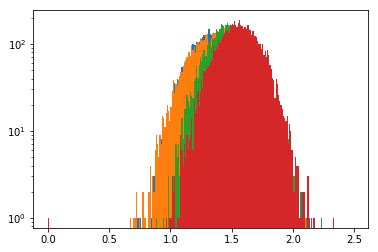

In [3]:
#plt.figure(figsize=(10, 4))
plt.hist(sim_matrix[110], bins=[i/100 for i in range(250)], log=True)
plt.hist(sim_matrix[1], bins=[i/100 for i in range(250)], log=True)
plt.hist(sim_matrix[100], bins=[i/100 for i in range(250)], log=True)
plt.hist(sim_matrix[470], bins=[i/100 for i in range(250)], log=True)

plt.show()

In [4]:
#Similarity is based  on the batch inputs not on the batch labels!
#This is important
#batch_inputs

In [71]:
results = []
for idx_row, row in enumerate(sim_matrix):
    #print (row)
    top_n_scores = [row[i] for i in np.argsort(row)[:2]]
    top_n_nodes = [i for i in np.argsort(row)[:2]]
    results.append([top_n_scores[1], top_n_nodes[1]])

In [72]:
results = np.array(results)

In [73]:
len(results)

7141

In [74]:
np.argsort(results[:,0])[:100]

array([3176, 3179,  939, 3708, 1585, 3720, 4108, 5577, 5509, 3775, 4703,
       6459,  746, 5989, 3057, 3942, 6637, 5993, 6806, 6370, 6051, 2344,
       2355, 6147,  234, 6162, 1577, 6773, 3891, 4436, 5835, 1029, 5731,
       1814, 5823, 5033, 3173, 4149, 5713, 6349,   82,  259, 2130, 1665,
       1546, 5342, 4596, 3876, 3603,  698, 6450, 7113, 5369, 4727, 2319,
       6340, 5911, 6111, 4047, 4130, 4749,   60,  337, 5302, 3406, 3374,
        325, 2911, 4183, 3615, 6882, 5567, 5769, 3217,  358, 5548, 4275,
       4096, 5458,   43, 1693, 4367, 1789, 2782, 2370, 3626, 6889, 4685,
       1298,  890, 4053, 1613, 5501,  178, 3029,  150, 5009, 5881,  751,
       2275], dtype=int64)

In [75]:
list_results = []

for node in range(len(results)):
    #print (node)
    sim = sim_matrix[node]

    top_n_scores = [sim[i] for i in np.argsort(sim)[:4]]
    top_n_nodes = [i for i in np.argsort(sim)[:4]]

    bottom_n_scores = [sim[i] for i in np.argsort(sim)[-4:]]
    bottom_n_nodes = [i for i in np.argsort(sim)[-4:]]
    
    top_nodes = [domain_inv_map[i] for i in top_n_nodes]
    bottom_nodes = [domain_inv_map[i] for i in bottom_n_nodes]
    
    df = pd.DataFrame([np.concatenate([top_nodes, top_n_scores, bottom_nodes, bottom_n_scores], axis=0)],
            columns=['top_0', 'top_1', 'top_2', 'top_3', 
                     'top_score_0', 'top_score_1', 'top_score_2', 'top_score_3',
                     'bottom_0', 'bottom_1', 'bottom_2', 'bottom_3', 
                     'bottom_score_0', 'bottom_score_1', 'bottom_score_2', 'bottom_score_3'])
    
    list_results.append(df)

In [76]:
df_all = pd.concat(list_results)

In [87]:
df_all.sort_values(by=['top_score_1', 'top_score_2', 'top_score_3'], inplace=True)

In [92]:
df_all['top_score_1'] = df_all['top_score_1'].apply(lambda x: float(x))

In [98]:
test_list = df_all[df_all['top_score_1']<0.5]\
[['top_0', 'top_1', 'top_2', 'top_3', 'bottom_0', 'bottom_1', 'bottom_2', 'bottom_3']].values

In [105]:
test_list = list(set([i for j in test_list for i in j]))

In [13]:
#df_all.to_csv('directed_graph_results_v5.csv', index=False)

In [14]:
k_means = MiniBatchKMeans(n_clusters=100)

In [15]:
k_means_clusters = k_means.fit_predict(final_embeddings)
k_means_coordinates = k_means.fit_transform(final_embeddings)

In [16]:
np.unique(k_means_clusters, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([ 55, 162,  70,  51, 133,  55,  78,  89,  69,  87, 142,  18,  82,
         94,  97,  94,   6,  73,  38,  58,  61,  79,  15,  11,  64,  86,
         65,  91, 223,  54,  69,  88,  80,  44,  64, 134,  67, 135, 109,
         90,  73,  73,  58,  23, 115,  99, 128, 142, 109, 125,  69,  96,
         52,  76,  57,  96,  38,  13,  43,  61,  24,  86,  58,  57,  43,
         72,  46,  91,  24,  41,   7,  62,  30,   2,  14,   2,  46,  40,
         61,  62, 190,  81,  93,  99,  35,  22,  83,  46,   5,  77,  41,
        123,  99, 105,  90, 123,  86,  

In [17]:
df_clusters = pd.DataFrame(list(zip(*[np.array([domain_inv_map[i] for i in range(len(k_means_clusters))]), 
                                      k_means_clusters])), columns=['domain', 'cluster'])

In [18]:
df_clusters[df_clusters['cluster']==2].head(10)

,domain,cluster
39,unknownworlds,2
94,ubmtechnology,2
136,pjatr,2
183,google-analytics,2
189,jewelsfromthecrown,2
460,relay,2
496,collegehumor,2
539,coloriage,2
671,sonypicturestelevision,2
691,spiegel-qc,2


In [ ]:
learning_grid = [10, 20]
perplexity_grid = [15, 20, 25]
metric_grid = ['l2', 'l1', 'euclidean',  'wminkowski', 'chebyshev', 'mahalanobis',
   'infinity', 'p', 'canberra',
  'haversine',  'minkowski',  
  'cityblock', 'braycurtis', 'manhattan']

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        for metric in metric_grid: 
            print (learning_rate, perplexity, metric)
            try:
                tsne = TSNE(perplexity=perplexity, n_components=2, learning_rate=learning_rate, n_iter=20000, 
                        verbose=9, metric=metric)

            #low_dim_embs = tsne.fit_transform(sim_matrix)
                low_dim_embs = tsne.fit_transform(final_embeddings)

                pickle.dump(low_dim_embs, \
open('dimensional_reduction/low_dim_embs_directed_domain_only_grid_%d_%d_%s_v5.pkl' % (learning_rate, perplexity, metric), 'wb'))
            except:
                continue

10 15 l2
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.016s...
[t-SNE] Computed neighbors for 7141 samples in 2.829s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilities for sample 6000 / 7141
[t-SNE] Computed conditional probabilities for sample 7000 / 7141
[t-SNE] Computed conditional probabilities for sample 7141 / 7141
[t-SNE] Mean sigma: 0.188597
[t-SNE] Computed conditional probabilities in 0.178s
[t-SNE] Iteration 50: error = 101.0111847, gradient norm = 0.0000000 (50 iterations in 10.418s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 101.011185
[t-SNE] It

[t-SNE] Iteration 150: error = 100.8405609, gradient norm = 0.0000191 (50 iterations in 25.557s)
[t-SNE] Iteration 200: error = 100.8403931, gradient norm = 0.0000034 (50 iterations in 25.195s)
[t-SNE] Iteration 250: error = 100.8403473, gradient norm = 0.0000008 (50 iterations in 25.911s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.840347
[t-SNE] Iteration 300: error = 5.9181576, gradient norm = 0.0001855 (50 iterations in 21.826s)
[t-SNE] Iteration 350: error = 5.5556436, gradient norm = 0.0044658 (50 iterations in 15.772s)
[t-SNE] Iteration 400: error = 5.1872211, gradient norm = 0.0017828 (50 iterations in 9.611s)
[t-SNE] Iteration 450: error = 5.0496445, gradient norm = 0.0012006 (50 iterations in 9.764s)
[t-SNE] Iteration 500: error = 4.9503279, gradient norm = 0.0009347 (50 iterations in 9.512s)
[t-SNE] Iteration 550: error = 4.8688045, gradient norm = 0.0007603 (50 iterations in 9.752s)
[t-SNE] Iteration 600: error = 4.7992792, gradient norm = 0.0006

[t-SNE] Iteration 4450: error = 4.0093212, gradient norm = 0.0000513 (50 iterations in 9.496s)
[t-SNE] Iteration 4500: error = 4.0089078, gradient norm = 0.0000501 (50 iterations in 9.426s)
[t-SNE] Iteration 4550: error = 4.0084515, gradient norm = 0.0000501 (50 iterations in 9.122s)
[t-SNE] Iteration 4600: error = 4.0081334, gradient norm = 0.0000493 (50 iterations in 9.186s)
[t-SNE] Iteration 4650: error = 4.0077877, gradient norm = 0.0000495 (50 iterations in 9.129s)
[t-SNE] Iteration 4700: error = 4.0074120, gradient norm = 0.0000485 (50 iterations in 9.261s)
[t-SNE] Iteration 4750: error = 4.0071054, gradient norm = 0.0000482 (50 iterations in 9.525s)
[t-SNE] Iteration 4800: error = 4.0068150, gradient norm = 0.0000475 (50 iterations in 9.490s)
[t-SNE] Iteration 4850: error = 4.0064688, gradient norm = 0.0000475 (50 iterations in 9.596s)
[t-SNE] Iteration 4900: error = 4.0061255, gradient norm = 0.0000474 (50 iterations in 9.763s)
[t-SNE] Iteration 4950: error = 4.0057721, gradien

[t-SNE] Iteration 8750: error = 3.9911830, gradient norm = 0.0000353 (50 iterations in 9.927s)
[t-SNE] Iteration 8800: error = 3.9909589, gradient norm = 0.0000356 (50 iterations in 9.868s)
[t-SNE] Iteration 8850: error = 3.9907529, gradient norm = 0.0000352 (50 iterations in 9.783s)
[t-SNE] Iteration 8900: error = 3.9905498, gradient norm = 0.0000358 (50 iterations in 9.759s)
[t-SNE] Iteration 8950: error = 3.9903460, gradient norm = 0.0000365 (50 iterations in 9.854s)
[t-SNE] Iteration 9000: error = 3.9901037, gradient norm = 0.0000376 (50 iterations in 9.969s)
[t-SNE] Iteration 9050: error = 3.9899476, gradient norm = 0.0000375 (50 iterations in 9.906s)
[t-SNE] Iteration 9100: error = 3.9898453, gradient norm = 0.0000369 (50 iterations in 9.814s)
[t-SNE] Iteration 9150: error = 3.9896553, gradient norm = 0.0000363 (50 iterations in 10.587s)
[t-SNE] Iteration 9200: error = 3.9895051, gradient norm = 0.0000350 (50 iterations in 10.406s)
[t-SNE] Iteration 9250: error = 3.9893153, gradi

[t-SNE] Iteration 13000: error = 3.9781647, gradient norm = 0.0000270 (50 iterations in 9.597s)
[t-SNE] Iteration 13050: error = 3.9780574, gradient norm = 0.0000267 (50 iterations in 9.621s)
[t-SNE] Iteration 13100: error = 3.9779258, gradient norm = 0.0000272 (50 iterations in 9.717s)
[t-SNE] Iteration 13150: error = 3.9778178, gradient norm = 0.0000267 (50 iterations in 9.641s)
[t-SNE] Iteration 13200: error = 3.9777184, gradient norm = 0.0000266 (50 iterations in 9.700s)
[t-SNE] Iteration 13250: error = 3.9775813, gradient norm = 0.0000270 (50 iterations in 9.657s)
[t-SNE] Iteration 13300: error = 3.9774396, gradient norm = 0.0000272 (50 iterations in 9.669s)
[t-SNE] Iteration 13350: error = 3.9773095, gradient norm = 0.0000269 (50 iterations in 9.605s)
[t-SNE] Iteration 13400: error = 3.9771988, gradient norm = 0.0000266 (50 iterations in 9.632s)
[t-SNE] Iteration 13450: error = 3.9771094, gradient norm = 0.0000263 (50 iterations in 9.605s)
[t-SNE] Iteration 13500: error = 3.97696

[t-SNE] Iteration 17250: error = 3.9686806, gradient norm = 0.0000233 (50 iterations in 10.330s)
[t-SNE] Iteration 17300: error = 3.9686358, gradient norm = 0.0000226 (50 iterations in 9.980s)
[t-SNE] Iteration 17350: error = 3.9685476, gradient norm = 0.0000235 (50 iterations in 10.146s)
[t-SNE] Iteration 17400: error = 3.9684725, gradient norm = 0.0000229 (50 iterations in 10.234s)
[t-SNE] Iteration 17450: error = 3.9684327, gradient norm = 0.0000226 (50 iterations in 10.067s)
[t-SNE] Iteration 17500: error = 3.9683857, gradient norm = 0.0000229 (50 iterations in 9.978s)
[t-SNE] Iteration 17550: error = 3.9683013, gradient norm = 0.0000225 (50 iterations in 10.012s)
[t-SNE] Iteration 17600: error = 3.9682155, gradient norm = 0.0000224 (50 iterations in 10.132s)
[t-SNE] Iteration 17650: error = 3.9681315, gradient norm = 0.0000218 (50 iterations in 10.093s)
[t-SNE] Iteration 17700: error = 3.9680831, gradient norm = 0.0000216 (50 iterations in 10.026s)
[t-SNE] Iteration 17750: error =

[t-SNE] Iteration 50: error = 101.4486694, gradient norm = 0.0000000 (50 iterations in 10.069s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 101.448669
[t-SNE] Iteration 100: error = 5.9690604, gradient norm = 0.0000001 (50 iterations in 8.357s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.969060
10 15 manhattan
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.011s...
[t-SNE] Computed neighbors for 7141 samples in 2.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilities for sample 6000 / 7141
[t-SNE] Computed cond

[t-SNE] Computed conditional probabilities in 0.219s
[t-SNE] Iteration 50: error = 97.6523209, gradient norm = 0.0000000 (50 iterations in 10.693s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 97.652321
[t-SNE] Iteration 100: error = 5.6526041, gradient norm = 0.0000000 (50 iterations in 9.162s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.652604
10 20 canberra
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.013s...
[t-SNE] Computed neighbors for 7141 samples in 4.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabil

[t-SNE] Iteration 50: error = 95.4141769, gradient norm = 0.0000000 (50 iterations in 11.213s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.414177
[t-SNE] Iteration 100: error = 5.4654226, gradient norm = 0.0000000 (50 iterations in 8.274s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.465423
10 25 euclidean
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.010s...
[t-SNE] Computed neighbors for 7141 samples in 2.901s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilities for sample 6000 / 7141
[t-SNE] Computed condit

[t-SNE] Iteration 50: error = 95.4141769, gradient norm = 0.0000000 (50 iterations in 11.854s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.414177
[t-SNE] Iteration 100: error = 5.4654226, gradient norm = 0.0000000 (50 iterations in 9.394s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.465423
10 25 braycurtis
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.014s...
[t-SNE] Computed neighbors for 7141 samples in 3.949s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilities for sample 6000 / 7141
[t-SNE] Computed condi

[t-SNE] Iteration 50: error = 100.5262070, gradient norm = 0.0000000 (50 iterations in 9.358s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 100.526207
[t-SNE] Iteration 100: error = 5.8923163, gradient norm = 0.0000000 (50 iterations in 6.486s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.892316
20 15 p
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.010s...
[t-SNE] Computed neighbors for 7141 samples in 2.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilities for sample 6000 / 7141
[t-SNE] Computed conditional p

[t-SNE] Iteration 3050: error = 4.0139842, gradient norm = 0.0000503 (50 iterations in 8.911s)
[t-SNE] Iteration 3100: error = 4.0133004, gradient norm = 0.0000508 (50 iterations in 8.930s)
[t-SNE] Iteration 3150: error = 4.0126634, gradient norm = 0.0000498 (50 iterations in 8.873s)
[t-SNE] Iteration 3200: error = 4.0120583, gradient norm = 0.0000496 (50 iterations in 8.980s)
[t-SNE] Iteration 3250: error = 4.0115418, gradient norm = 0.0000490 (50 iterations in 8.926s)
[t-SNE] Iteration 3300: error = 4.0109587, gradient norm = 0.0000481 (50 iterations in 8.921s)
[t-SNE] Iteration 3350: error = 4.0104499, gradient norm = 0.0000480 (50 iterations in 8.699s)
[t-SNE] Iteration 3400: error = 4.0099597, gradient norm = 0.0000473 (50 iterations in 8.933s)
[t-SNE] Iteration 3450: error = 4.0095682, gradient norm = 0.0000475 (50 iterations in 8.876s)
[t-SNE] Iteration 3500: error = 4.0092192, gradient norm = 0.0000471 (50 iterations in 8.861s)
[t-SNE] Iteration 3550: error = 4.0088630, gradien

[t-SNE] Iteration 7400: error = 3.9892917, gradient norm = 0.0000311 (50 iterations in 9.067s)
[t-SNE] Iteration 7450: error = 3.9890218, gradient norm = 0.0000312 (50 iterations in 9.060s)
[t-SNE] Iteration 7500: error = 3.9887495, gradient norm = 0.0000311 (50 iterations in 9.079s)
[t-SNE] Iteration 7550: error = 3.9885359, gradient norm = 0.0000308 (50 iterations in 9.099s)
[t-SNE] Iteration 7600: error = 3.9883325, gradient norm = 0.0000307 (50 iterations in 9.088s)
[t-SNE] Iteration 7650: error = 3.9881124, gradient norm = 0.0000320 (50 iterations in 9.153s)
[t-SNE] Iteration 7700: error = 3.9878993, gradient norm = 0.0000313 (50 iterations in 9.164s)
[t-SNE] Iteration 7750: error = 3.9877198, gradient norm = 0.0000311 (50 iterations in 9.491s)
[t-SNE] Iteration 7800: error = 3.9874952, gradient norm = 0.0000301 (50 iterations in 9.112s)
[t-SNE] Iteration 7850: error = 3.9873188, gradient norm = 0.0000303 (50 iterations in 9.131s)
[t-SNE] Iteration 7900: error = 3.9871387, gradien

[t-SNE] Iteration 11700: error = 3.9767265, gradient norm = 0.0000243 (50 iterations in 10.382s)
[t-SNE] Iteration 11750: error = 3.9765418, gradient norm = 0.0000235 (50 iterations in 10.388s)
[t-SNE] Iteration 11800: error = 3.9764392, gradient norm = 0.0000244 (50 iterations in 10.277s)
[t-SNE] Iteration 11850: error = 3.9763258, gradient norm = 0.0000235 (50 iterations in 10.344s)
[t-SNE] Iteration 11900: error = 3.9762182, gradient norm = 0.0000251 (50 iterations in 10.336s)
[t-SNE] Iteration 11950: error = 3.9761002, gradient norm = 0.0000237 (50 iterations in 10.425s)
[t-SNE] Iteration 12000: error = 3.9759834, gradient norm = 0.0000226 (50 iterations in 10.357s)
[t-SNE] Iteration 12050: error = 3.9758852, gradient norm = 0.0000222 (50 iterations in 10.480s)
[t-SNE] Iteration 12100: error = 3.9757941, gradient norm = 0.0000229 (50 iterations in 10.394s)
[t-SNE] Iteration 12150: error = 3.9756281, gradient norm = 0.0000223 (50 iterations in 10.396s)
[t-SNE] Iteration 12200: error

[t-SNE] Iteration 15950: error = 3.9697604, gradient norm = 0.0000197 (50 iterations in 12.017s)
[t-SNE] Iteration 16000: error = 3.9696860, gradient norm = 0.0000205 (50 iterations in 10.891s)
[t-SNE] Iteration 16050: error = 3.9695947, gradient norm = 0.0000200 (50 iterations in 10.593s)
[t-SNE] Iteration 16100: error = 3.9695463, gradient norm = 0.0000205 (50 iterations in 10.293s)
[t-SNE] Iteration 16150: error = 3.9694922, gradient norm = 0.0000201 (50 iterations in 10.458s)
[t-SNE] Iteration 16200: error = 3.9694312, gradient norm = 0.0000205 (50 iterations in 10.716s)
[t-SNE] Iteration 16250: error = 3.9693732, gradient norm = 0.0000203 (50 iterations in 10.961s)
[t-SNE] Iteration 16300: error = 3.9693048, gradient norm = 0.0000209 (50 iterations in 11.057s)
[t-SNE] Iteration 16350: error = 3.9692452, gradient norm = 0.0000205 (50 iterations in 10.946s)
[t-SNE] Iteration 16400: error = 3.9691455, gradient norm = 0.0000204 (50 iterations in 10.637s)
[t-SNE] Iteration 16450: error

[t-SNE] Iteration 50: error = 101.0111847, gradient norm = 0.0000000 (50 iterations in 9.879s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 101.011185
[t-SNE] Iteration 100: error = 5.9327946, gradient norm = 0.0000000 (50 iterations in 7.572s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.932795
20 15 cityblock
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.014s...
[t-SNE] Computed neighbors for 7141 samples in 2.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilities for sample 6000 / 7141
[t-SNE] Computed condi

[t-SNE] Iteration 3050: error = 3.8013000, gradient norm = 0.0000434 (50 iterations in 9.439s)
[t-SNE] Iteration 3100: error = 3.8003538, gradient norm = 0.0000440 (50 iterations in 9.333s)
[t-SNE] Iteration 3150: error = 3.7994373, gradient norm = 0.0000468 (50 iterations in 9.042s)
[t-SNE] Iteration 3200: error = 3.7986174, gradient norm = 0.0000456 (50 iterations in 9.026s)
[t-SNE] Iteration 3250: error = 3.7979429, gradient norm = 0.0000463 (50 iterations in 9.360s)
[t-SNE] Iteration 3300: error = 3.7972157, gradient norm = 0.0000444 (50 iterations in 9.082s)
[t-SNE] Iteration 3350: error = 3.7966406, gradient norm = 0.0000427 (50 iterations in 9.222s)
[t-SNE] Iteration 3400: error = 3.7960126, gradient norm = 0.0000419 (50 iterations in 9.134s)
[t-SNE] Iteration 3450: error = 3.7954102, gradient norm = 0.0000405 (50 iterations in 8.958s)
[t-SNE] Iteration 3500: error = 3.7948182, gradient norm = 0.0000400 (50 iterations in 9.131s)
[t-SNE] Iteration 3550: error = 3.7941914, gradien

[t-SNE] Iteration 7350: error = 3.7686923, gradient norm = 0.0000267 (50 iterations in 10.541s)
[t-SNE] Iteration 7400: error = 3.7685409, gradient norm = 0.0000261 (50 iterations in 11.236s)
[t-SNE] Iteration 7450: error = 3.7683232, gradient norm = 0.0000261 (50 iterations in 9.749s)
[t-SNE] Iteration 7500: error = 3.7681561, gradient norm = 0.0000256 (50 iterations in 10.363s)
[t-SNE] Iteration 7550: error = 3.7679720, gradient norm = 0.0000267 (50 iterations in 10.251s)
[t-SNE] Iteration 7600: error = 3.7677824, gradient norm = 0.0000288 (50 iterations in 10.027s)
[t-SNE] Iteration 7650: error = 3.7675924, gradient norm = 0.0000273 (50 iterations in 9.436s)
[t-SNE] Iteration 7700: error = 3.7673805, gradient norm = 0.0000284 (50 iterations in 9.608s)
[t-SNE] Iteration 7750: error = 3.7671983, gradient norm = 0.0000277 (50 iterations in 9.452s)
[t-SNE] Iteration 7800: error = 3.7670493, gradient norm = 0.0000268 (50 iterations in 9.262s)
[t-SNE] Iteration 7850: error = 3.7668509, gr

[t-SNE] Iteration 11650: error = 3.7576051, gradient norm = 0.0000225 (50 iterations in 11.727s)
[t-SNE] Iteration 11700: error = 3.7575536, gradient norm = 0.0000216 (50 iterations in 10.845s)
[t-SNE] Iteration 11750: error = 3.7574973, gradient norm = 0.0000212 (50 iterations in 10.197s)
[t-SNE] Iteration 11800: error = 3.7573886, gradient norm = 0.0000220 (50 iterations in 10.465s)
[t-SNE] Iteration 11850: error = 3.7573071, gradient norm = 0.0000210 (50 iterations in 11.603s)
[t-SNE] Iteration 11900: error = 3.7572432, gradient norm = 0.0000216 (50 iterations in 10.251s)
[t-SNE] Iteration 11950: error = 3.7571113, gradient norm = 0.0000219 (50 iterations in 11.082s)
[t-SNE] Iteration 12000: error = 3.7570424, gradient norm = 0.0000226 (50 iterations in 11.292s)
[t-SNE] Iteration 12050: error = 3.7569823, gradient norm = 0.0000213 (50 iterations in 11.222s)
[t-SNE] Iteration 12100: error = 3.7568848, gradient norm = 0.0000218 (50 iterations in 11.789s)
[t-SNE] Iteration 12150: error

[t-SNE] Iteration 15950: error = 3.7517996, gradient norm = 0.0000213 (50 iterations in 9.278s)
[t-SNE] Iteration 16000: error = 3.7517545, gradient norm = 0.0000198 (50 iterations in 9.145s)
[t-SNE] Iteration 16050: error = 3.7516968, gradient norm = 0.0000198 (50 iterations in 9.391s)
[t-SNE] Iteration 16100: error = 3.7516546, gradient norm = 0.0000185 (50 iterations in 9.409s)
[t-SNE] Iteration 16150: error = 3.7515953, gradient norm = 0.0000199 (50 iterations in 9.814s)
[t-SNE] Iteration 16200: error = 3.7515426, gradient norm = 0.0000190 (50 iterations in 9.346s)
[t-SNE] Iteration 16250: error = 3.7514906, gradient norm = 0.0000200 (50 iterations in 10.061s)
[t-SNE] Iteration 16300: error = 3.7514060, gradient norm = 0.0000187 (50 iterations in 9.542s)
[t-SNE] Iteration 16350: error = 3.7513556, gradient norm = 0.0000193 (50 iterations in 10.307s)
[t-SNE] Iteration 16400: error = 3.7512906, gradient norm = 0.0000180 (50 iterations in 9.965s)
[t-SNE] Iteration 16450: error = 3.751

[t-SNE] Computed conditional probabilities in 0.218s
[t-SNE] Iteration 50: error = 101.3679504, gradient norm = 0.0000000 (50 iterations in 10.169s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 101.367950
[t-SNE] Iteration 100: error = 5.9620867, gradient norm = 0.0000000 (50 iterations in 7.650s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.962087
20 20 l2
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.013s...
[t-SNE] Computed neighbors for 7141 samples in 3.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities for sample 5000 / 7141
[t-SNE] Computed conditional probabilitie

[t-SNE] Computed conditional probabilities in 0.203s
[t-SNE] Iteration 50: error = 97.5380249, gradient norm = 0.0000000 (50 iterations in 10.493s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 97.538025
[t-SNE] Iteration 100: error = 5.6430826, gradient norm = 0.0000000 (50 iterations in 7.608s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] Error after 100 iterations: 5.643083
20 20 haversine
[t-SNE] Computing 61 nearest neighbors...
20 20 minkowski
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7141 samples in 0.011s...
[t-SNE] Computed neighbors for 7141 samples in 2.963s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7141
[t-SNE] Computed conditional probabilities for sample 2000 / 7141
[t-SNE] Computed conditional probabilities for sample 3000 / 7141
[t-SNE] Computed conditional probabilities for sample 4000 / 7141
[t-SNE] Computed conditional probabilities f

In [3]:
%matplotlib notebook
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

In [19]:
colors = ['b' for i in range(len(domain_inv_map))]

In [4]:
labels = [domain_inv_map[i] for i in range(len(domain_inv_map))]

#pickle.dump(low_dim_embs, open('low_dim_embs.pkl', 'wb'))

#low_dim_embs = pickle.load(open('low_dim_embs_grid_1_5.pkl', 'rb'))

In [110]:
labels_test_args = [labels.index(i) for i in test_list]

In [115]:
len(labels_test)

280

In [113]:
labels_test = [labels[i] for i in labels_test_args]

In [6]:
import matplotlib
import matplotlib.cm as cm

10 15 euclidean


<IPython.core.display.Javascript object>


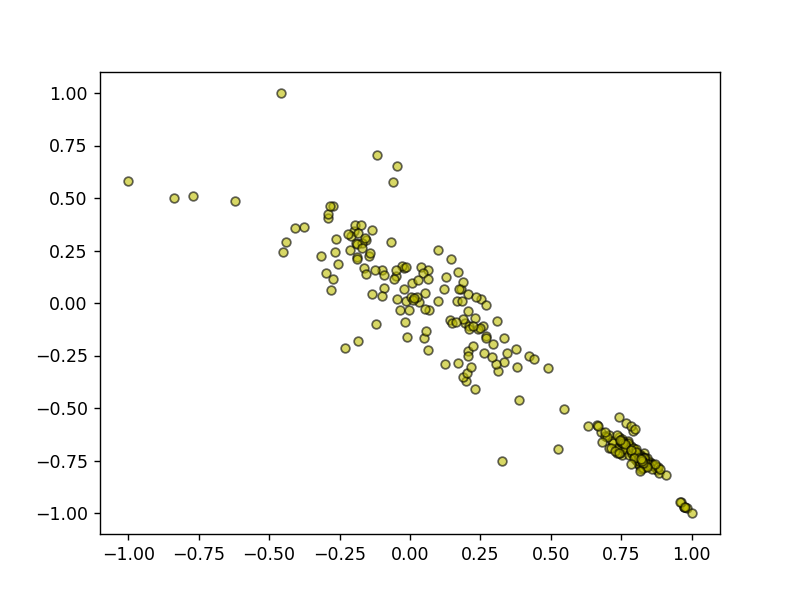

In [117]:
learning_grid = [10]
perplexity_grid = [15]
metric_grid = ['euclidean']
#learning_grid = [5, 10, 20]
#perplexity_grid = [15, 20, 25]
#metric_grid = ['cosine', 'l2', 'l1', 'euclidean', 'kulsinski', 'wminkowski', 'chebyshev', 'mahalanobis',
#  'sokalmichener', 'rogerstanimoto', 'infinity', 'p', 'canberra',
#  'haversine', 'sokalsneath', 'minkowski', 'pyfunc', 
#  'cityblock', 'braycurtis', 'manhattan']

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        for metric in metric_grid:
            print (learning_rate, perplexity, metric)
            try:
                low_dim_embs = \
                pickle.load(open('dimensional_reduction/low_dim_embs_directed_domain_only_grid_%d_%d_%s_v5.pkl' % \
                                 (learning_rate, perplexity, metric), 'rb'))
                scaler = MinMaxScaler(feature_range=[-1, 1])
                low_dim_embs = [low_dim_embs[i] for i in labels_test_args]
                low_dim_embs = scaler.fit_transform(low_dim_embs)
                
                
                fig, ax = plt.subplots()
                #for i in range(100):
                #    if i==0: 
                #        c = 'b'
                #        marker_size=15
                #    else: 
                #        c= 'r'
                #        marker_size=5
                #    points = ax.plot(low_dim_embs[:,0][i], low_dim_embs[:,1][i], 'o', color=c,
                #             mec='k', ms=marker_size, mew=1, alpha=.6)
                points = ax.plot(low_dim_embs[:,0], low_dim_embs[:,1], 'o', color='y',
                             mec='k', ms=5, mew=1, alpha=.6)
                #points = ax.scatter(low_dim_embs[:,0], low_dim_embs[:,1],color=colors)
                
                fig.savefig('low_dim_embs_directed_domain_only_grid_%d_%d_%s.png' % (learning_rate, perplexity, metric))
            except:
                continue
tooltip = plugins.PointHTMLTooltip(points[0], labels_test)

plugins.connect(fig, tooltip)
#plugins.connect(fig)

In [118]:
mpld3.display()

In [68]:
low_dim_embs[labels.index('twitter')]

array([ 0.70620728, -0.5827471 ], dtype=float32)

In [69]:
low_dim_embs[labels.index('facebook')]

array([ 0.6632272 , -0.53771514], dtype=float32)